In [1]:
import numpy as np
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '3'

import tensorflow as tf


from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation, Lambda, BatchNormalization, LeakyReLU, Softmax, ReLU
from tensorflow.keras.models import Model

from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.linalg import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

import matplotlib.pyplot as plt
import sys 
sys.path.append('..')
from layers.sorted_filters_with_map import SortedConv2DWithMap
from layers.channel_roll import ChannelRoll
import datetime


In [2]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()
#tf.debugging.disable_traceback_filtering()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_xla())
print(tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices("GPU"))
print(tf.__version__ )

Num GPUs Available:  1
True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.11.0-dev20220812


In [3]:
input_net = Input((32, 32, 3))

#y = layers.Conv2D(filters=32, kernel_size = 3, activation=LeakyReLU(alpha=0.1), padding='SAME')(input_net)
y, map1 = SortedConv2DWithMap(filters=8,activation=LeakyReLU(alpha=0.1), padding='SAME', layer_num=1)(input_net)
#y = ChannelRoll()([y, map1])
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 

y, map2 = SortedConv2DWithMap(filters=16,activation=LeakyReLU(alpha=0.1), padding='SAME', layer_num=2)(y)
y, map2 = SortedConv2DWithMap(filters=16,activation=LeakyReLU(alpha=0.1), padding='SAME', layer_num=1)(y)

#y = ChannelRoll()([y, map2])
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 

y, map3 = SortedConv2DWithMap(filters=32,activation=LeakyReLU(alpha=0.1), padding='SAME', layer_num=3)(y)
y, map3 = SortedConv2DWithMap(filters=32,activation=LeakyReLU(alpha=0.1), padding='SAME', layer_num=1)(y)
y, map3 = SortedConv2DWithMap(filters=32,activation=LeakyReLU(alpha=0.1), padding='SAME', layer_num=3)(y)

#y = ChannelRoll()([y, map3])
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 


y = layers.BatchNormalization(axis=-1)(y)
y = layers.Dropout(0.5)(y)

y = layers.Flatten()(y)
y = layers.Dense(512, activation=ReLU())(y)
y = layers.BatchNormalization(axis=-1)(y)
y = layers.Dropout(0.5)(y)
output_net  = layers.Dense(100, activation=Softmax())(y)

model = Model(inputs = input_net, outputs = output_net)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sorted_conv2d_with_map (Sor  ((None, 32, 32, 8),      81        
 tedConv2DWithMap)            (None, 32, 32, 1))                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 sorted_conv2d_with_map_1 (S  ((None, 16, 16, 16),     401       
 ortedConv2DWithMap)          (None, 16, 16, 1))                 
                                                                 
 sorted_conv2d_with_map_2 (S  ((None, 16, 16, 16),     785       
 ortedConv2DWithMap)          (None, 16, 16, 1))             

In [4]:
print(map1)
tf.linspace(tf.squeeze(map1, -1), tf.math.add(tf.squeeze(map1, -1),10), 10, axis=-1)

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), name='sorted_conv2d_with_map/Repeat_1/Reshape_1:0', description="created by layer 'sorted_conv2d_with_map'")


<KerasTensor: shape=(None, None, None, None) dtype=float32 (created by layer 'tf.linspace')>

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


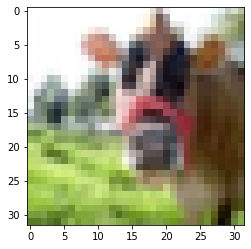

In [5]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

plt.imshow(x_train[0,:,:,:])



In [6]:
model = Model(inputs = input_net, outputs = output_net)

initial_learning_rate =  0.01

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    alpha = 1e-6,
    m_mul=0.999,
    first_decay_steps = 20)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

log_dir = "logs_shift_experiments/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 2)

model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)


checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

batch_size = 256
epochs = 10
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/10
196/196 [==============================] - 77s 126ms/step - loss: 5.0593 - accuracy: 0.0303 - top-5-accuracy: 0.1241 - val_loss: 5.2274 - val_accuracy: 0.0150 - val_top-5-accuracy: 0.0717
Epoch 2/10
196/196 [==============================] - 12s 62ms/step - loss: 4.2910 - accuracy: 0.0510 - top-5-accuracy: 0.1884 - val_loss: 4.8016 - val_accuracy: 0.0193 - val_top-5-accuracy: 0.0965
Epoch 3/10
196/196 [==============================] - 12s 60ms/step - loss: 4.1143 - accuracy: 0.0684 - top-5-accuracy: 0.2345 - val_loss: 4.1810 - val_accuracy: 0.0611 - val_top-5-accuracy: 0.2158
Epoch 4/10
196/196 [==============================] - 12s 61ms/step - loss: 4.0788 - accuracy: 0.0714 - top-5-accuracy: 0.2440 - val_loss: 4.5459 - val_accuracy: 0.0354 - val_top-5-accuracy: 0.1306
Epoch 5/10
196/196 [==============================] - 13s 65ms/step - loss: 3.9664 - accuracy: 0.0900 - top-5-accuracy: 0.2792 - val_loss: 4.0800 - val_accuracy: 0.0772 - val_top-5-accuracy: 0.2476
Epoch 6/1

In [7]:
%tensorboard --logdir logs_shift_experiments/fit

UsageError: Line magic function `%tensorboard` not found.


(32, 32, 3)
o (1, 16, 16, 8)
(1, 32, 32, 1)
[2.9375]


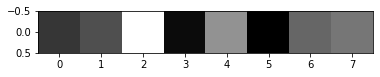

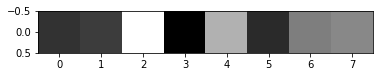

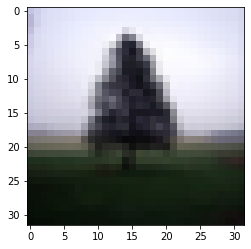

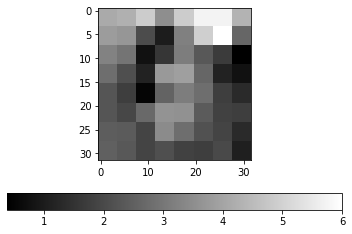

In [8]:

n = 109
X = x_test[n]
print(X.shape)

get_layer_output = K.function([model.input], model.layers[1].output)
out = np.array(get_layer_output(np.expand_dims(X, axis=0))[0])
map = np.array(get_layer_output(np.expand_dims(X, axis=0))[1])

get_layer_output = K.function([model.input], model.layers[2].output)
out_shift = np.array(get_layer_output(np.expand_dims(X, axis=0)))





plt.figure(1)  
print('o', out_shift.shape)
im = plt.imshow(out[:, 10, 5, :], cmap='gray')   
#plt.colorbar(im, ticks=range(8), orientation="horizontal")

plt.figure(2)  
im = plt.imshow(out_shift[:,10, 5, :], cmap='gray')  
#plt.colorbar(im, ticks=range(8), orientation="horizontal")

print(map.shape)
print(map[0, 10, 5])



plt.figure(3)  
im = plt.imshow(X, cmap='gray')  

#plt.colorbar(im, ticks=range(32), orientation="horizontal")
        

plt.figure(4)  
im = plt.imshow(map[0], cmap='gray')  

plt.colorbar(im, ticks=range(32), orientation="horizontal")
        


In [9]:
print(index[0, 0, 1, ])
print(out[0, 0, 1, ])
print(out_left[0, 0, 1, ])
print(out_right[0, 0, 1, ])

print(map[0, 0, 1 ])
print(out_shifted[0, 0, 1, ])



NameError: name 'index' is not defined

In [ ]:
tf.RaggedTensor.from_tensor(out1, padding=0, ragged_rank=3, row_splits_dtype=tf.int32)

<tf.RaggedTensor [[[[0.0, 0.7518008, 0.0, 0.07587218, 0.30510306, 2.2470028, 3.6672583,
    2.52381, 5.557482, 5.59272]                                       ,
   [0.0, 4.088064, 2.1949782, 1.414401, 0.75688887, 2.8039901, 4.155519,
    1.7276574, 6.167313, 5.2518997]                                     ,
   [0.0, 4.4181137, 2.3985133, 1.5343769, 0.76932454, 2.8721192, 4.250799,
    1.7071693, 6.320815, 5.3395777]                                       ,
   ..., [], [], []],
  [[0.0, 2.1077445, 1.8260822, 2.5864766, 3.3052006, 6.4447064, 8.379952,
    6.242959, 10.074447, 8.111772]                                       ,
   [0.0, 7.434674, 6.298918, 6.0896688, 5.316704, 9.055386, 10.544804,
    6.841101, 11.702086, 7.553796]                                    ,
   [0.0, 8.077639, 6.7795377, 6.480469, 5.586491, 9.394007, 10.914227,
    6.928129, 12.056224, 7.6800666]                                   ,
   ..., [], [], []],
  [[0.0, 2.020402, 1.713198, 2.4499805, 3.1396997, 6.3285174, 8.2

In [ ]:
tf.RaggedTensor.from_nested_row_splits(out, padding=-, ragged_rank=3, row_splits_dtype=tf.int32)

In [ ]:
model.layers[5].scale_a

In [ ]:
i = tf.random.uniform(shape=[1,5,5,3], maxval=5, dtype=tf.int32)
idx = tf.random.uniform(shape=[1,5,5,3], minval = 0, maxval=2, dtype=tf.int32)
#m = tf.expand_dims(m, axis=-1)
n = i.shape[-1]

In [ ]:
idx = tf.cast(tf.linspace(tf.squeeze(m, -1), tf.squeeze(m + n-1, -1), n, axis=-1) , tf.int64)  

In [ ]:
i
ChannelRoll()([i,m ])

x (1, 5, 5, 3)


UnknownError: Exception encountered when calling layer "channel_roll_1" (type ChannelRoll).

JIT compilation failed. [Op:FloorMod]

Call arguments received by layer "channel_roll_1" (type ChannelRoll):
  • inputs=['tf.Tensor(shape=(1, 5, 5, 3), dtype=int32)', 'tf.Tensor(shape=(1, 5, 5, 1), dtype=int32)']
  • training=None

In [ ]:
out = tf.gather(i, idx, batch_dims=3)
out

<tf.Tensor: shape=(1, 5, 5, 3), dtype=int32, numpy=
array([[[[4, 4, 0],
         [2, 1, 1],
         [0, 1, 0],
         [0, 4, 4],
         [2, 2, 4]],

        [[2, 2, 1],
         [3, 2, 3],
         [3, 3, 0],
         [0, 1, 0],
         [3, 3, 3]],

        [[0, 3, 0],
         [4, 4, 4],
         [1, 0, 1],
         [2, 1, 1],
         [1, 1, 2]],

        [[1, 4, 4],
         [1, 4, 1],
         [2, 2, 2],
         [2, 2, 2],
         [3, 1, 1]],

        [[3, 2, 3],
         [2, 2, 3],
         [3, 2, 3],
         [2, 2, 2],
         [1, 1, 1]]]])>

In [ ]:
idx

<tf.Tensor: shape=(1, 5, 5, 3), dtype=int32, numpy=
array([[[[0, 0, 1],
         [1, 0, 0],
         [0, 1, 0],
         [1, 0, 0],
         [1, 1, 0]],

        [[0, 0, 1],
         [1, 0, 1],
         [1, 1, 0],
         [1, 0, 1],
         [1, 0, 0]],

        [[1, 0, 1],
         [1, 1, 1],
         [1, 0, 1],
         [0, 1, 1],
         [0, 0, 1]],

        [[1, 0, 0],
         [1, 0, 1],
         [1, 1, 1],
         [1, 0, 1],
         [0, 1, 1]],

        [[0, 1, 0],
         [1, 1, 0],
         [1, 0, 1],
         [1, 1, 1],
         [1, 1, 1]]]])>

In [ ]:
i

<tf.Tensor: shape=(1, 5, 5, 3), dtype=int32, numpy=
array([[[[4, 0, 0],
         [1, 2, 1],
         [0, 1, 4],
         [4, 0, 4],
         [4, 2, 0]],

        [[2, 1, 0],
         [2, 3, 2],
         [0, 3, 2],
         [1, 0, 4],
         [3, 3, 4]],

        [[3, 0, 0],
         [2, 4, 1],
         [0, 1, 3],
         [2, 1, 2],
         [1, 2, 1]],

        [[4, 1, 0],
         [4, 1, 4],
         [2, 2, 1],
         [2, 2, 0],
         [3, 1, 3]],

        [[3, 2, 3],
         [3, 2, 2],
         [2, 3, 0],
         [3, 2, 4],
         [4, 1, 0]]]])>

In [ ]:
def test()
tf.cast(tf.linspace([[3,1,2], [4,5,6]], [[13, 11, 12], [14,15,16]], 2), dtype=tf.int64) 

<tf.Tensor: shape=(1, 2, 3), dtype=int64, numpy=
array([[[3, 1, 2],
        [4, 5, 6]]], dtype=int64)>

In [ ]:
tf.repeat([tf.expand_dims(tf.linspace(0.0, math.pi,8, axis=0),axis=0)], 3, axis=1)

<tf.Tensor: shape=(1, 3, 8), dtype=float32, numpy=
array([[[0.        , 0.44879895, 0.8975979 , 1.3463969 , 1.7951958 ,
         2.2439947 , 2.6927938 , 3.1415927 ],
        [0.        , 0.44879895, 0.8975979 , 1.3463969 , 1.7951958 ,
         2.2439947 , 2.6927938 , 3.1415927 ],
        [0.        , 0.44879895, 0.8975979 , 1.3463969 , 1.7951958 ,
         2.2439947 , 2.6927938 , 3.1415927 ]]], dtype=float32)>

In [ ]:
tf.random.normal([1, 3, 8], mean=tf.linspace(0.0, math.pi,8, axis=0), stddev=/math.pi)

<tf.Tensor: shape=(1, 3, 8), dtype=float32, numpy=
array([[[ 0.03463585,  0.3829091 ,  1.005945  ,  1.3406746 ,
          1.7537367 ,  2.153503  ,  2.322995  ,  3.2828467 ],
        [ 0.1563656 ,  0.2840916 ,  0.57580715,  1.1498641 ,
          1.9196583 ,  2.332367  ,  2.2251093 ,  3.3511965 ],
        [-0.41903237, -0.0289492 ,  0.49376875,  1.0420393 ,
          1.6572069 ,  2.361961  ,  2.2272432 ,  3.1394715 ]]],
      dtype=float32)>